In [1]:
import torch

In [2]:
from model import EmbeddingNet
model = EmbeddingNet(1, 64, 64)
model.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
from train_omniglot import get_dataloader

In [4]:
test_dataloader = get_dataloader('test')

== Dataset: Found 33840 items 
== Dataset: Found 1692 classes


In [5]:
model.eval()
with torch.no_grad():
    test_iter = iter(test_dataloader)
    for batch in test_iter:
        x, y = batch
        x_embed = model(x)
        break

In [12]:
print(y)
print(x_embed.size())

tensor([1140, 1140, 1140, 1049,  539,  944,  539, 1140, 1049, 1049, 1140,  539,
        1140, 1049, 1049, 1049, 1049,  944, 1140,  539,  539, 1140,  539,  539,
         944, 1255,  944, 1140,  944,  944,  944,  539,  944,  539, 1049,  944,
         944, 1255, 1140, 1140, 1255,  944,  539, 1049, 1049, 1049,  539,  539,
         539,  944,  944,  539, 1140, 1255, 1049, 1049, 1140, 1049, 1255, 1049,
        1140,  944, 1255, 1255, 1140, 1049, 1140, 1255, 1255, 1255, 1049,  944,
        1255, 1049,  539,  539,  944, 1140,  944, 1140,  539,  944, 1049,  539,
         944, 1255, 1255, 1140,  539, 1255,  539, 1255,  944, 1255, 1255, 1140,
        1255, 1049, 1255, 1255])
torch.Size([100, 64])


In [13]:
n_support = 5

unique_classes, input_to_class_idx = torch.unique(y, sorted=False,
                                                        return_inverse=True)
n_class = len(unique_classes)
query_list = []
prototype_list = []

for k in range(n_class):
    
    input_idx = torch.flatten((input_to_class_idx == k).nonzero(
                                                        as_tuple = False))
    input_k = torch.index_select(x_embed, 0, input_idx)
    support_k = input_k[:n_support]
    query_k = input_k[n_support:]

    prototype_k = torch.mean(support_k, 0)
            
    query_list.append(query_k)
    prototype_list.append(prototype_k)

    query = torch.stack(query_list)
    prototype = torch.stack(prototype_list)

In [14]:
print(query.size())
print(prototype.size())

torch.Size([5, 15, 64])
torch.Size([5, 64])


In [15]:
query_re = query.view(-1, 64)

In [18]:
print(query_re.size())
print(query_re[15] == query[1,0])
print(query_re[31] == query[2,0])
print(query_re[31] == query[2,1])

torch.Size([75, 64])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False])
tensor([True, True, True, True, True, Tru

In [23]:
prototype_query = torch.cat([prototype, query_re]).detach().numpy()
print(prototype_query.shape)

(80, 64)


In [24]:
from sklearn.manifold import TSNE

In [25]:
prototype_query_tsne = TSNE(n_components=2).fit_transform(prototype_query)

In [26]:
prototype_query_tsne.shape

(80, 2)

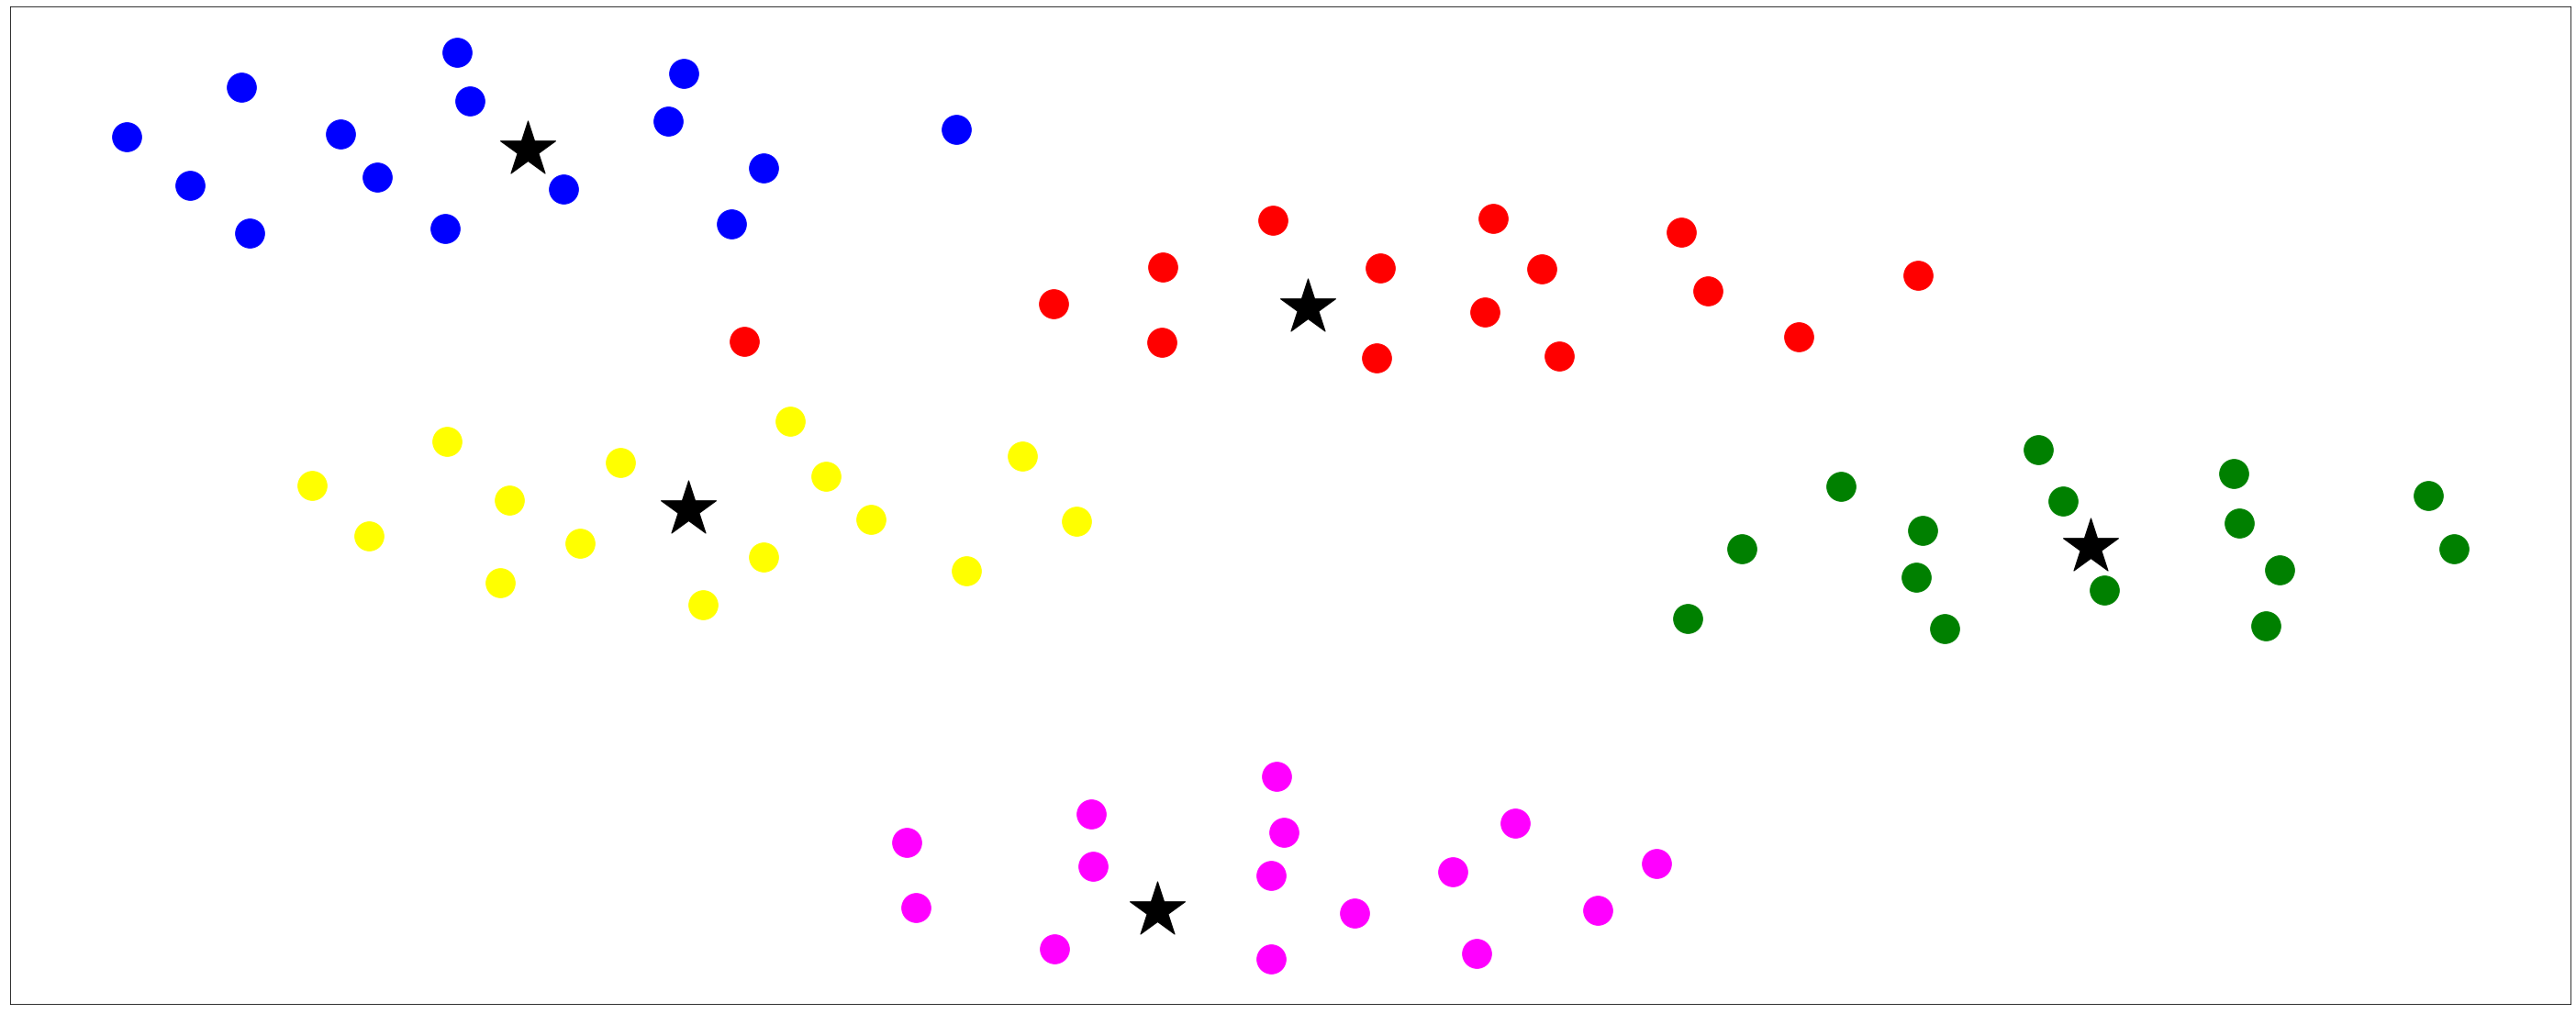

In [53]:
import matplotlib.pyplot as plt

prototype_tsne = prototype_query_tsne[:5]
query_tsne = prototype_query_tsne[5:]

f = plt.figure(figsize=(50,20))

plt.scatter(prototype_tsne[:,0], prototype_tsne[:,1], s=4000, marker="*", c="black")
plt.scatter(query_tsne[:15,0], query_tsne[:15,1], s=1000, c="blue")
plt.scatter(query_tsne[15:30,0], query_tsne[15:30,1], s=1000, c="yellow")
plt.scatter(query_tsne[30:45,0], query_tsne[30:45,1], s=1000, c="green")
plt.scatter(query_tsne[45:60,0], query_tsne[45:60,1], s=1000, c="red")
plt.scatter(query_tsne[60:,0], query_tsne[60:,1], s=1000, c="magenta")
plt.xticks([])
plt.yticks([])
f.savefig("visualization.png", bbox_inches='tight')